The material presented is adapted from *Python Machine Learning 3rd Edition* by [Sebastian Raschka](https://sebastianraschka.com) & Vahid Mirjalili, Packt Publishing Ltd. 2019 (code available on [GitHub](https://github.com/rasbt/python-machine-learning-book-3rd-edition)).

## Overview
- [Sentiment Analysis Revisited](#Sentiment-Analysis-Revisited)
  - [Example: Sentiment analysis of movie reviews](#Example:-Sentiment-analysis-of-movie-reviews)
    - [Preprocessing (old version)](#Preprocessing-(old-version))
    - [Preprocessing (NEW)](#Preprocessing-(NEW))
    - [Data Representation](#Data-Representation)
    - [Batching](#Batching)
    - [Training the bidirectional RNN with selectable type](#Training-the-bidirectional-RNN-with-selectable-type)
  - [Stopping earlier](#Stopping-earlier)


##  Sentiment Analysis Revisited
---

Here, we want to employ additional techniques from the `nltk`-library for preprocessing in order to hopefully further improve on the sentiment analysis we performed [earlier](../07_RNN_MAT/07b_RNN_Sentiment.ipynb).

<span style="color:blue">Please pay attention to the changes section <b>Preprocessing (NEW)</b></span>

In [1]:
import os

import numpy as np
import pandas as pd
import random
import collections

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
import torchtext
from torchtext.data import get_tokenizer
from torch import nn

import datetime as dt

In [2]:
# importing module for training loop
%cd ..
from train_loop import train_for_epochs, validate, plot_history
%cd -

/data/AH/AML_2024
/data/AH/AML_2024/08_NLP_Intro_MAT


/data/AH/AML_2024/venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
CUDA_AVAILABLE = torch.cuda.is_available()
print(f'CUDA_AVAILABLE = {CUDA_AVAILABLE}')

USE_ONLY_CPU = False

CUDA_AVAILABLE = True


In [4]:
random.seed(42)     # python random generator
np.random.seed(42)  # numpy random generator

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

### Example: Sentiment analysis of movie reviews
---
* reading data as *external data*
* also available as [PyTorch Dataset](https://pytorch.org/text/stable/datasets.html#imdb)

In [5]:
df = pd.read_csv('Data/movie_data.csv', encoding='utf-8')
df.tail()

,review,sentiment
49995,"OK, lets start with the best. the building. al...",0
49996,The British 'heritage film' industry is out of...,0
49997,I don't even know where to begin on this one. ...,0
49998,Richard Tyler is a little boy who is scared of...,0
49999,I waited long to watch this movie. Also becaus...,1


#### Preprocessing (old version)

In [6]:
# Step 1: create a dataset

target = df.pop('sentiment')

values = df.values

## inspection:
for i, (t, v) in enumerate(zip(target, values)):
    print(v[0][:50], t)
    if i > 5:
        break

In 1974, the teenager Martha Moxley (Maggie Grace) 1
OK... so... I really like Kris Kristofferson and h 0
***SPOILER*** Do not read this, if you think about 0
hi for all the people who have seen this wonderful 1
I recently bought the DVD, forgetting just how muc 0
Leave it to Braik to put on a good show. Finally h 1
Nathan Detroit (Frank Sinatra) is the manager of t 1


#### Preprocessing (NEW)

First, let's remove stopwords. Additionally, we get rid of all punctuations.

In [7]:
import re
import nltk
nltk.download('stopwords')

stopwords_eng = set(nltk.corpus.stopwords.words("english"))
# print(stopwords_eng)
# let's keep a few words, which we think might be useful for sentiments (bad sentiment)
keep = ['not', 'doesn', 'don', 'couldn', 'won', 'wasn']
for keep_word in keep:
    stopwords_eng.remove(keep_word)

def clean_text(text):
    text = text.lower() # convert to lowercase
    text = re.sub("[^a-z]", " ", text) #remove all punctuation
    words = [word for word in text.split() if word not in stopwords_eng]
    text = " ".join(words)
    return text

reviews = df.review
reviews = reviews.map(clean_text)
df.review = reviews

values = df.values

## inspection:
for i, (t, v) in enumerate(zip(target, reviews)):
    print(v[:50], t)
    if i > 5:
        break

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ahafner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


teenager martha moxley maggie grace moves high cla 1
ok really like kris kristofferson usual easy going 0
spoiler not read think watching movie although wou 0
hi people seen wonderful movie im sure thet would  1
recently bought dvd forgetting much hated movie ve 0
leave braik put good show finally zorak living liv 1
nathan detroit frank sinatra manager new york long 1


As we can see, our new preprocessing removes stopwords and all punctuations. The reviews are not nicely readable anymore, but hopefully we can get better results.

Also, we will apply Lemmatization using the Lemmatizer from WordNet:

In [8]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
lemmas = list()

def clean_text2(text):
    words = [lemmatizer.lemmatize(word, pos='v') for word in text.split()]
    text = " ".join(words)
    return text

reviews = df.review
reviews = reviews.map(clean_text2)
df.review = reviews

## inspection:
for i, (t, v) in enumerate(zip(target, reviews)):
    print(v[:50], t)
    if i > 5:
        break

[nltk_data] Downloading package wordnet to /home/ahafner/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


teenager martha moxley maggie grace move high clas 1
ok really like kris kristofferson usual easy go de 0
spoiler not read think watch movie although would  0
hi people see wonderful movie im sure thet would l 1
recently buy dvd forget much hat movie version cho 0
leave braik put good show finally zorak live live  1
nathan detroit frank sinatra manager new york long 1


As you can see, especially verbs are now different. For example in the first line, "moves" has been converted to "move".

Please note that the lemmatizer actually requires a correct POS tagging; In order to keep things simple here, we tell him  that all words are verbs (pos='v'). As you know from the lecture, this could possibly cause some mistakes for some specific nouns.

 * **tokenizer (and encoder)**
   * `torchtext.data.utils.get_tokenize`: https://pytorch.org/text/stable/data_utils.html

In [9]:
# build a pytorch dataset
class ReviewDataset(Dataset):
    def __init__(self, target, values):
        
        self.target = target
        self.values = values
        # setup tokenizer
        tokenizer_name = 'basic_english' 
        tokenizer = get_tokenizer(tokenizer_name)
        self.tokenizer = get_tokenizer(tokenizer_name)
        # setup vocab
        counter_obj = collections.Counter()
        for v in values:
            tokens = tokenizer(v)
            counter_obj.update(tokens)
        self.vocab = torchtext.vocab.vocab(counter_obj, min_freq=1, specials=['<unk>'])
        # set a default index for out of vocabulary tokens
        self.vocab.set_default_index(-1)
        print('Vocab-size:', len(self.vocab))
        
    def __encode(self, value):
        tokens = self.tokenizer(value)
        return torch.tensor(self.vocab.lookup_indices(tokens))
    
    def __len__(self):
        return len(self.target)
    
    def __getitem__(self, idx):
        return self.__encode(self.values[idx]), torch.tensor(target[idx]).float()
    
dataset = ReviewDataset(target=target, values=reviews)

Vocab-size: 86551


As can be observed, the vocabulary size is now much smaller than previously.

 * **train/validation/test split**

In [10]:
# setup train test split
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [30000, 5000, 15000])
print(f'Len train set: {len(train_set)}')
print(f'Len val set: {len(val_set)}')
print(f'Len test set: {len(test_set)}')

Len train set: 30000
Len val set: 5000
Len test set: 15000


#### Data Representation

In [11]:
for i in range(5):
    example = dataset[i]
    print('Sequence length:', example[0].shape)
    
example

Sequence length: torch.Size([132])
Sequence length: torch.Size([120])
Sequence length: torch.Size([162])
Sequence length: torch.Size([36])
Sequence length: torch.Size([69])


(tensor([322, 323, 199, 324, 298, 325,  73, 228, 326, 119, 327, 328, 252, 329,
         144,  75, 243,  70,  70, 144, 252, 330, 249, 331, 332, 333, 334, 317,
         335, 336,  70,  70, 317, 337, 338, 339,  98, 340, 315, 341, 332, 342,
         343, 137, 330, 344,  70,  70, 345, 346, 300, 347,  70,  70, 173, 137,
         287, 337, 348,  93, 349, 350, 351, 241, 352, 327, 353, 354, 355]),
 tensor(0.))

#### Batching
The movie review data now needs to be batched (with padding) for training.

In [12]:
# setup data loader
def batch_and_pad(data):
    values = [d[0] for d in data]
    labels = [d[1].unsqueeze(0) for d in data]
    return torch.nn.utils.rnn.pad_sequence(values, batch_first=True), torch.stack(labels)
    
train_loader = DataLoader(train_set, batch_size=32, collate_fn=batch_and_pad)
test_loader = DataLoader(test_set, batch_size=32, collate_fn=batch_and_pad)
val_loader = DataLoader(val_set, batch_size=32, collate_fn=batch_and_pad)

example_batch = next(iter(train_loader))
example_batch[0].shape

torch.Size([32, 565])

#### Training the bidirectional RNN with selectable type
The bidirectional LSTM has already been compiled, so we can now just train it.

In [13]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, recurrent_type='RNN', bidirectional=False, n_recurrent_layers=1):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0)
        if recurrent_type == 'RNN':
            self.rnn = nn.RNN(embedding_dim, hidden_units, batch_first=True, bidirectional=bidirectional, num_layers=n_recurrent_layers)
        elif recurrent_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_units, batch_first=True, bidirectional=bidirectional, num_layers=n_recurrent_layers)
        elif recurrent_type == 'GRU':
            self.rnn = nn.GRU(embedding_dim, hidden_units, batch_first=True, bidirectional=bidirectional, num_layers=n_recurrent_layers)
        self.fc1 = nn.Linear(hidden_units * 2 if bidirectional else hidden_units, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        self.num_directions = 2 if bidirectional else 1
        self.hidden_units = hidden_units
        self.recurrent_type = recurrent_type

    def forward(self, x):
        batch_size, seq_len = x.shape
        embedded = self.embedding(x)
        #lstm also returns the cell hidden state
        if self.recurrent_type == "LSTM":
            output, (hidden, cell_hidden) = self.rnn(embedded)
        else:
            output, hidden = self.rnn(embedded)
        # Concatenate the final hidden states from both directions if bidirectional
        if self.rnn.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        x = self.fc1(hidden)
        x = self.relu(x)
        x = self.fc2(x)
        output = self.sigmoid(x)
        return output

embedding_dim = 20
vocab_size = len(dataset.vocab)

# preprocessing has already been done
rnn_type = 'LSTM'
model = RNNModel(vocab_size, embedding_dim, 64, recurrent_type=rnn_type, n_recurrent_layers=1, bidirectional=True)
model

RNNModel(
  (embedding): Embedding(86551, 20, padding_idx=0)
  (rnn): LSTM(20, 64, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() and not USE_ONLY_CPU else "cpu")
print(f'Using {device} for training')

Using cuda for training


In [15]:
NUM_EPOCHS = 10

# Move the model weight to the desired device
model.to(device)

# Define the loss function
criterion = nn.BCELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters())

# run training
start_train = dt.datetime.now()
print(f'{rnn_type} training started: {start_train}')
history = train_for_epochs(device, NUM_EPOCHS, model, train_loader, val_loader, optimizer, criterion)
finish_train = dt.datetime.now()
print(f'{rnn_type} training finished {finish_train} (duration: {finish_train - start_train})')

LSTM training started: 2024-12-02 13:22:20.161109


  0%|          | 0/10 [00:00<?, ?it/s]

LSTM training finished 2024-12-02 13:23:18.446591 (duration: 0:00:58.285482)


In [16]:
## evaluate on the test data
test_loss, test_accuracy = validate(device, model, test_loader, criterion)
print(f'\nTest Acc. for {rnn_type} after {NUM_EPOCHS} epochs: {test_accuracy:.2f}%')


Test Acc. for LSTM after 10 epochs: 86.76%


When comparing the training here to the previous training, we can see that the training accuracy is already much higher in the first epoch. Also, the training is nearly twice as fast. This is a good sign, obviously we reduced the complexity.

However, when comparing the accuracy on the test set, we cannot observe an improvement (~87% in both cases). The text preprocessing seems not to have an important impact on the classification performance on this dataset. 

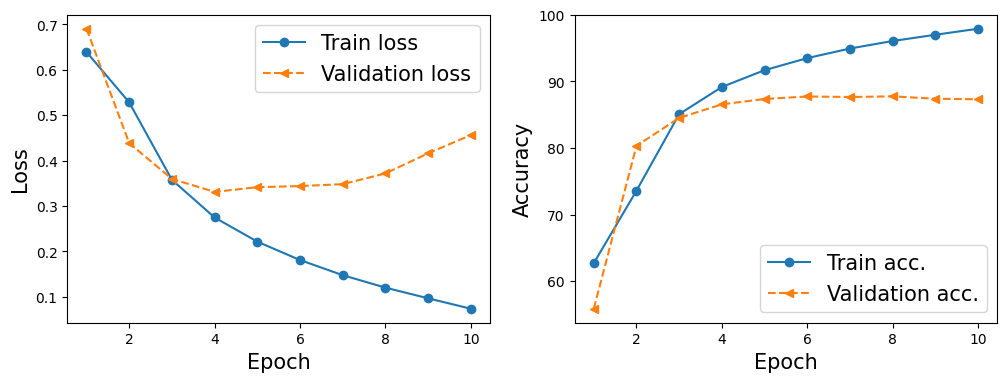

In [17]:
loss_train_hist = history['train']['loss']
acc_train_hist = history['train']['accuracy']
loss_val_hist = history['val']['loss']
acc_val_hist = history['val']['accuracy']

plot_history(loss_train_hist, acc_train_hist, loss_val_hist, acc_val_hist)

plt.show()

Again, compare the training/validation accuracy here to your previous material. It depends a bit on whether you are training on a CPU or GPU and other parameters, but you should observe that the validation accuracy is slightly decreasing. This is a sign of overfitting, maybe the training should already be stopped after the 4th epoch. (accuracy is 85%).

Please note once more that in order to improve a model, you should first have a look at what you can do in preprocessing - remember what we were even able to do with the simple RNN when using the appropriate sequence length.

In [18]:
# if needed: save model
if not os.path.exists('models'):
    os.mkdir('models')

torch.save(model, f'models/Bidir-{rnn_type}-{NUM_EPOCHS}ep-full-length-preprocessing.pt')

### Stopping earlier
Let's see what we get, if we do stop after 4 epochs.

In [19]:
#re-instantiate
rnn_type = 'LSTM'
model = RNNModel(vocab_size, embedding_dim, 64, recurrent_type=rnn_type, n_recurrent_layers=1, bidirectional=True)
total_epochs = 0

NUM_EPOCHS = 4

# Move the model weight to the desired device
model.to(device)

# Define the loss function
criterion = nn.BCELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters())

# run training
start_train = dt.datetime.now()
print(f'{rnn_type} training after {total_epochs} epochs started for {NUM_EPOCHS} epochs: {start_train}')
history = train_for_epochs(device, NUM_EPOCHS, model, train_loader, val_loader, optimizer, criterion)
finish_train = dt.datetime.now()
total_epochs += NUM_EPOCHS
print(f'{rnn_type} training finished {finish_train} (duration: {finish_train - start_train})')

LSTM training after 0 epochs started for 4 epochs: 2024-12-02 13:23:20.401916


  0%|          | 0/4 [00:00<?, ?it/s]

LSTM training finished 2024-12-02 13:23:43.530373 (duration: 0:00:23.128457)


In [20]:
## evaluate on the test data
test_loss, test_accuracy = validate(device, model, test_loader, criterion)
print(f'\nTest Acc. for {rnn_type} after {total_epochs} epochs: {test_accuracy:.2f}%')


Test Acc. for LSTM after 4 epochs: 84.13%


The additional training does seem to have improved the model and early stopping does not seem warranted. Let us try two more epochs and continue the process, until we are satisfied.

In [21]:
NUM_EPOCHS = 2
# run training
start_train = dt.datetime.now()
print(f'{rnn_type} training after {total_epochs} epochs started for {NUM_EPOCHS} epochs: {start_train}')
history = train_for_epochs(device, NUM_EPOCHS, model, train_loader, val_loader, optimizer, criterion)
finish_train = dt.datetime.now()
total_epochs += NUM_EPOCHS
print(f'{rnn_type} training finished {finish_train} (duration: {finish_train - start_train})')

LSTM training after 4 epochs started for 2 epochs: 2024-12-02 13:23:45.336083


  0%|          | 0/2 [00:00<?, ?it/s]

LSTM training finished 2024-12-02 13:23:56.950835 (duration: 0:00:11.614752)


In [22]:
## evaluate on the test data
test_loss, test_accuracy = validate(device, model, test_loader, criterion)
print(f'\nTest Acc. for {rnn_type} after {total_epochs} epochs: {test_accuracy:.2f}%')


Test Acc. for LSTM after 6 epochs: 86.67%
